# Wholesale Credit Risk Modeling - Deep Joshi

#### Credit risk is a term used to quantify the likelihood of potential losses arising from a borrower’s failure to pay for the borrowed service or difficulties in meeting the contractual obligations. 

#### Credit risk modeling is an effective technique used in the financial services on a daily basis, in order to determine the level of risk associated while extending any service or credit to the borrower.  However, there is a huge difference between the services offered  to the retail customers and wholesale customers. The services offered to institutional customers, companies with strong portfolio, government agencies, local governments, pension funds, etc. is often referred to as wholesale banking. Wholesale services involve large quantities of lending and borrowing among the banks, in the inter-bank market. The service exchanged between these entities can be in any form. Some of the services that come under the wholesale domain and offered as credits include:

#### •	Currency Conversion
#### •	Underwriting
#### •	Working Capital
#### •	Investment Consulting
#### •	Fleet and Equipment Leasing 
#### •	Merchant Banking

#### These services have separate rules and regulations while defining the contractual documents between the entities and the services are not offered to individuals or small firms. 

#### There are various acronyms and metrics used to determine the risk level, however, the below three are commonly used:
#### •	Loss Given Default (LGD)
#### •	Exposure at Default (EAD)
#### •	Probability of Default (PD)

####  And, among these three, Probability of Default (PD) is most frequently used. Basically, it allows us to understand the likelihood of default i.e. in simple terms, it is the inability of a borrower to repay for the services he/she has availed from the lender.






## Problem Definition 

#### The advancements in the field of machine learning has revolutionized the applications in and techniques in the risk management area, and data has been a key driver in this area. The purpose of this project is to analyze the financial information of obligors and develop a predictive classification model using machine learning, that is able to predict defaults. 

## Loading the data from the data sources 

#### The data required for modeling is stored in the form of two flatfiles:
#### 1. 'financial_data.csv' -> This file contains the relevant financial information about the obligors.
#### 2. 'default_data.csv' -> This file contains the loan ID's of obligors who have defaulted loans.

#### In order to start with the analysis, we will first have to join the data from both the sources. This can be done by joining the tabular data with each other based on column column between them i.e. 'LOAN_ID'

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA
from sklearn.svm import SVC
%matplotlib inline


In [2]:
# Reading the datasets from both the files
sheet1 = pd.read_csv(r"C:\Users\Deep Joshi\Desktop\Mom and Dad\Mom\Sheet-1.csv")
sheet2 = pd.read_csv(r"C:\Users\Deep Joshi\Desktop\Mom and Dad\Mom\Sheet-2.csv")

# Discarding the observation count from the default dataframe
sheet2 = sheet2.iloc[:,1:]

# Printing the information about the dataframe
print('FINANCIAL DATA \n---------------------------------------- \n')
print(sheet1.info())
print('\nDEFAULT DATA \n---------------------------------------- \n')
print(sheet2.info())

FINANCIAL DATA 
---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
LOAN_ID           10000 non-null object
PD_RISK_RATING    10000 non-null int64
X1                10000 non-null object
X2                9000 non-null float64
X3                10000 non-null float64
X4                9000 non-null float64
X5                10000 non-null float64
X6                10000 non-null float64
X7                10000 non-null float64
X8                10000 non-null float64
X9                10000 non-null float64
X10               10000 non-null float64
X11               10000 non-null float64
X12               10000 non-null float64
X13               10000 non-null object
X14               10000 non-null object
X15               10000 non-null object
dtypes: float64(11), int64(1), object(5)
memory usage: 1.3+ MB
None

DEFAULT DATA 
---------------------------------------- 

<class 'pandas.core

#### Constructing an additional feature 'Default_Ind' into the default dataset with value as '1', to indicate the default.

In [3]:
# Introducing an additional column 'Default_Ind' into the default dataframe with value 1, indicating the customer is in default list
sheet2['Default_Ind'] = 1
# Full outer join on LOAN_ID
# NOTE: On performing the join, customers not in default will have NaN values in 'Default_Ind'
merged = pd.merge(sheet1,sheet2, on="LOAN_ID", how="outer")
merged.info()
# As expected, merged dataframe information indicates only 129 non-null values in 'Default_Ind'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 18 columns):
LOAN_ID           10000 non-null object
PD_RISK_RATING    10000 non-null int64
X1                10000 non-null object
X2                9000 non-null float64
X3                10000 non-null float64
X4                9000 non-null float64
X5                10000 non-null float64
X6                10000 non-null float64
X7                10000 non-null float64
X8                10000 non-null float64
X9                10000 non-null float64
X10               10000 non-null float64
X11               10000 non-null float64
X12               10000 non-null float64
X13               10000 non-null object
X14               10000 non-null object
X15               10000 non-null object
Default_Ind       129 non-null float64
dtypes: float64(12), int64(1), object(5)
memory usage: 1.4+ MB


#### We have successfully merged the data from both the sources by performing full outer join on 'LOAN_ID' 

#### The dataset consists of 10,000 observations with 18 features, out of which features X1 to X15 are available for modeling, LOAN_ID identifies the  individual obligors and Default_Ind represents our target.

#### Categorical Independent Features: X1,X13,X14,X15

#### Numerical Independent Features: X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12, PD_RISK_RATING

#### Target Variable: Default_Ind
#### ----------> Value 0 indicates 'Not Default'
#### ----------> Value 1 indicates 'Default'


In [4]:
# Replacing NaN values with 0 in 'Default_Ind'
merged['Default_Ind'].fillna(0, inplace=True)

# Type conversion: float -> int
merged['Default_Ind'] = merged['Default_Ind'].astype(int)

# Discarding LOAN_ID from the dataset as we have the merged dataset ready
merged = merged.iloc[:,1:]

# Printing first 5 observations after merging the datasets
merged.head(5)

PD_RISK_RATING                X1        X2        X3           X4  \
0               2               C&I  0.113703  0.795355  1156188.606   
1               4     CRE Permanent  0.622299  0.364232          NaN   
2               2  CRE Construction  0.609275  0.821238  1046682.630   
3               1  CRE Construction  0.623379  0.613073  1085325.470   
4               2  CRE Construction  0.860915  0.709228  1051378.694   

         X5        X6          X7        X8         X9       X10       X11  \
0  0.090963  0.963879  120.606137  0.966454  -6.884990  0.195105  1.093855   
1  0.497840  0.606212  109.621719  0.440733 -10.010214  1.600637  1.146797   
2  0.487420  0.296746   94.520306  0.007491  10.726384  0.434792  1.050520   
3  0.498704  0.641079   94.933871  0.910976   0.476127  0.341299  1.011261   
4  0.688732  0.339430  106.331848  0.939269   0.251195  0.967834  1.002241   

        X12 X13   X14  X15  Default_Ind  
0  0.890361   C  T982  Yes            0  
1  0.857632   B  X456  Yes            0  
2  0.150828   B  T982  Yes            0  
3  0.120293   B  T982   No            0  
4  0.329663   B  R567  Yes            0

In [5]:
# Writing the merged dataset to the csv file
#merged.to_csv('merged.csv')

#### We have dropped the feature 'LOAN_ID' from our merged dataset as it no longer required for analysis and it's purpose was only to distinguish individual obligors and for joining the datasources 

## Exploratory Data Analysis (EDA) 

#### Exploratory Data Analysis (EDA) is a set of procedures performed  to analyze the dataset, by employing various graphical and visualization techniques. The main goal of performing EDA is to gain various insights about the dataset, by uncovering the way the data has been structured within the dataset. It allows us to detect and understand the missing values, inconsistent entries, noisy values, outliers, anomalies, cardinality, distribution, descriptive statistics etc. Furthermore, it allows us to understand the effect of various features on the target, individually and in combination. In a nutshell, EDA plays a pivotal role in providing directions to our analysis and has the ability to influence future stages of machine learning

### 1. Checking Target Skewness/Imbalance 

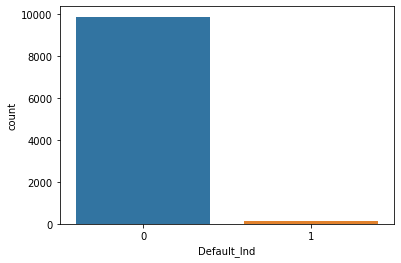

In [6]:
# Checking target imbalance by ploting a bar graph
sns.countplot('Default_Ind', data=merged)

#### The above visual clearly denotes that there is a high degree of target imbalance in our dataset.  We have a huge count of obligors that were able to repay for the availed services vs those who were not able to do so within the given time. However, the target class imbalance is expected when we are dealing such subjects.

### 2. Detecting features with missing values 

In [7]:
# Missing value percentage in each feature
features_with_missing_values = [features for features in merged.columns if merged[features].isnull().sum()>1]
print('Percentage of Missing Values \n-----------------------------')
for feature in features_with_missing_values:
    print(feature,' -->', np.round(merged[feature].isnull().mean()*100, 4), '% missing values')

Percentage of Missing Values 
-----------------------------
X2  --> 10.0 % missing values
X4  --> 10.0 % missing values


#### We have 2 features 'X2' and 'X4' with missing values and the count is sufficient enough for us to NOT drop these observations.  10% of missing values within each feature can significantly hamper the performance of our model, if not handled properly. Hence, we need to handle such entries with a great care

### 3. Effect of missing values on target 

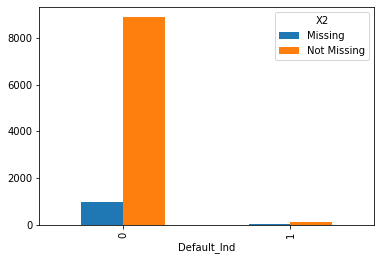

Out of all obligors making into the loan default list, 15.5 % have missing values in  X2


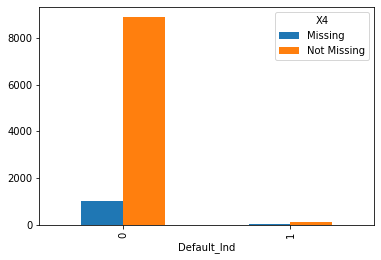

Out of all obligors making into the loan default list, 5.43 % have missing values in  X4


In [8]:
# Understanding the effect of missing values on target
for feature in features_with_missing_values:
    temp_dataset = merged.copy()
    temp_dataset[feature] = np.where(temp_dataset[feature].isnull(),'Missing','Not Missing')
    default = temp_dataset[feature][temp_dataset['Default_Ind'] == 1].count()
    missing_and_default = temp_dataset[feature][(temp_dataset[feature] == 'Missing') & (temp_dataset['Default_Ind'] == 1)].count()
    percentage = np.round((missing_and_default / default) * 100,2)
    
    temp_dataset.groupby([feature,'Default_Ind'])['Default_Ind'].count().unstack(feature).plot.bar()
    plt.show()
    
    
    print('Out of all obligors making into the loan default list,',percentage,'% have missing values in ',feature)

#### As we can see from the above graphs, we have 15.5% of missing values in 'X2' that end up into the default list. Similarly, the percentage in 'X4' is 5.4%. Since, we have only 129 observations in the default list, 15.5% and 5.4% is a huge proportion and needs to be handled with utmost care.  

### 4. Numerical Features 

In [9]:
# Separating numerical features from the dataset
numerical_features = [feature for feature in merged.columns if merged[feature].dtypes != 'O']
print('Total number of numerical features: ', len(numerical_features))

# Dataset containing numerical values only
merged[numerical_features].head()

Total number of numerical features:  13


PD_RISK_RATING        X2        X3           X4        X5        X6  \
0               2  0.113703  0.795355  1156188.606  0.090963  0.963879   
1               4  0.622299  0.364232          NaN  0.497840  0.606212   
2               2  0.609275  0.821238  1046682.630  0.487420  0.296746   
3               1  0.623379  0.613073  1085325.470  0.498704  0.641079   
4               2  0.860915  0.709228  1051378.694  0.688732  0.339430   

           X7        X8         X9       X10       X11       X12  Default_Ind  
0  120.606137  0.966454  -6.884990  0.195105  1.093855  0.890361            0  
1  109.621719  0.440733 -10.010214  1.600637  1.146797  0.857632            0  
2   94.520306  0.007491  10.726384  0.434792  1.050520  0.150828            0  
3   94.933871  0.910976   0.476127  0.341299  1.011261  0.120293            0  
4  106.331848  0.939269   0.251195  0.967834  1.002241  0.329663            0

### Discrete Features 

In [10]:
# Laet's see if we have any discrete feature within the numerical feature
discrete_feature=[feature for feature in numerical_features if len(merged[feature].unique())<25]
print("Total number of discrete features:  {} ----> {}".format(len(discrete_feature),discrete_feature))
 

Total number of discrete features:  2 ----> ['PD_RISK_RATING', 'Default_Ind']


### Effect of discrete feature on target 

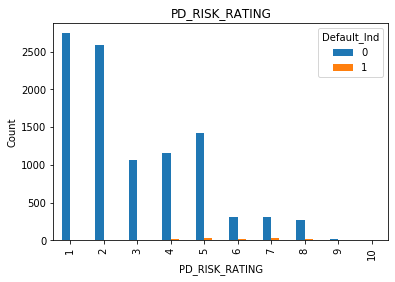

In [11]:
# Since, 'Default_Ind' is our target variable, let's try to visualize the relationship of 'PD_RISK_RATING' with the target
merged.groupby(['PD_RISK_RATING','Default_Ind'])['Default_Ind'].count().unstack('Default_Ind').plot.bar()
plt.xlabel('PD_RISK_RATING')
plt.ylabel('Count')
plt.title('PD_RISK_RATING')
plt.show()

#### As we can see from the above visual, 'PD_RISK_RATING' does play a significant role in determining the default, as we have obligors in the dataset, ending up in the defaulters list having rating greater than or equal to 3. However, it depends on other traits as well and it is not a guaranteed behaviour (We still have huge count of obligors having higher rating and not ending up in the defaulters list ). Let's try to plot the KDE plot grouped by the target. 

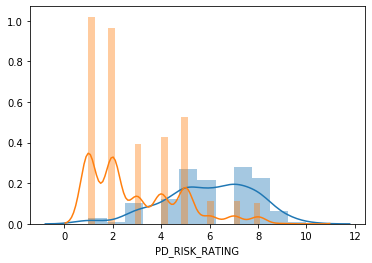

In [12]:
# Grouping the feature by target feature and plotting kernel density plot
sns.distplot(merged.loc[merged['Default_Ind'] == 1, 'PD_RISK_RATING'], label = 'Default_Ind == 1')
sns.distplot(merged.loc[merged['Default_Ind'] == 0, 'PD_RISK_RATING'], label = 'Default_Ind == 0')

#### The above graph makes it more clear as we can clearly visualize the impact of having a high risk rating towards predicting the default.  

### Continuous Features 

In [13]:
# Separating continuous features from the dataset for analysis
continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature]
print("Total number of continuous features:  {} ----> {}".format(len(continuous_feature),continuous_feature))

Total number of continuous features:  11 ----> ['X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12']


### Analyzing the distribution of continuous features

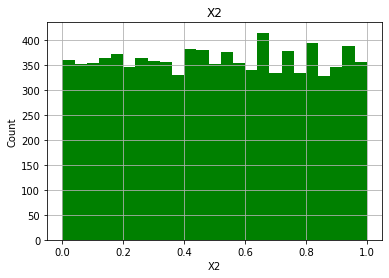

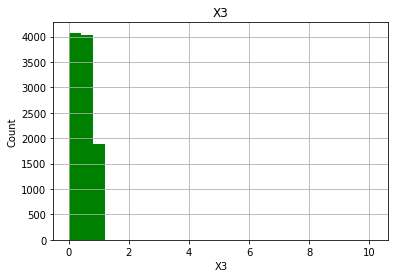

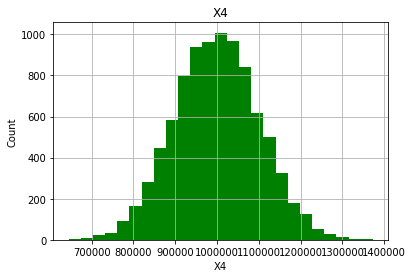

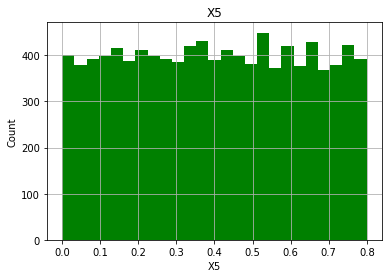

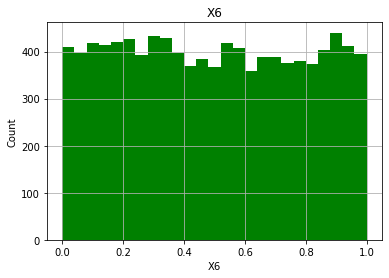

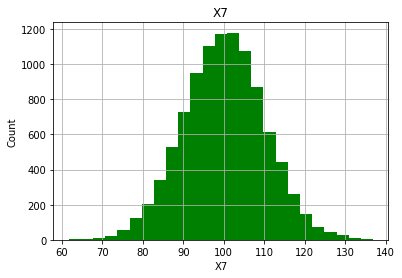

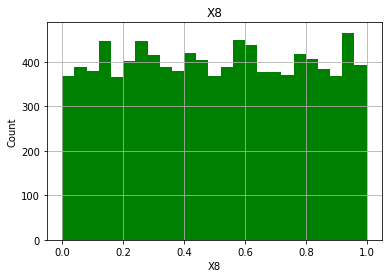

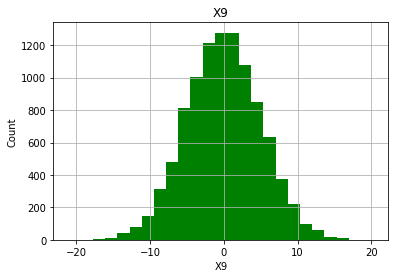

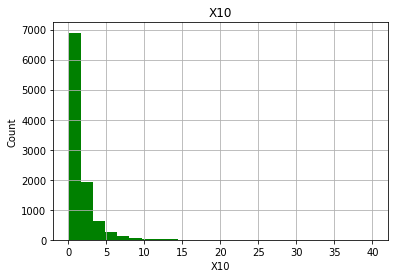

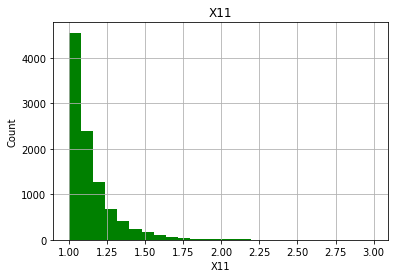

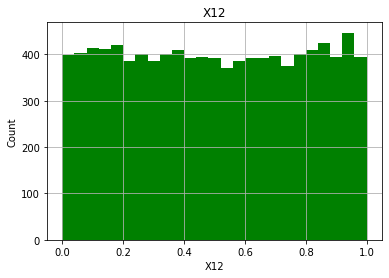

In [14]:
for feature in continuous_feature:
    temp_continuous_feature=merged.copy()
    temp_continuous_feature[feature].hist(bins=25, color='green')
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

#### By plotting the histograms of individual features and by analyzing the distribution shapes, we infer that:
#### 1. Features 'X4','X7' and 'X9' have bell shaped curve and respresent normal distribution. 
#### 2. The features 'X2', 'X5', 'X6', 'X8' and 'X12' have a distribution shape that is similar to uniform/multimodal distribution, have several peaks and provides little information about data. The reason for having such shape may be due to several data properties being combined to form a sample as a whole.  For such distributions, in order to generate patterns/insights, different groupings can be tried. We can also break down the data and analyze the data properties separately. 
#### 3. Features 'X3', 'X10' and 'X11' have an asymmetrical distribution and are highly skewed towards right

### Visualizing the effect of continuos features on target 

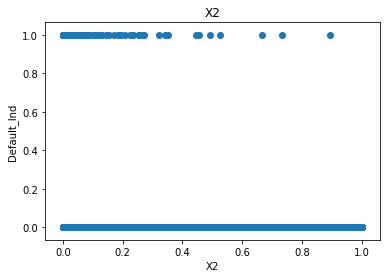

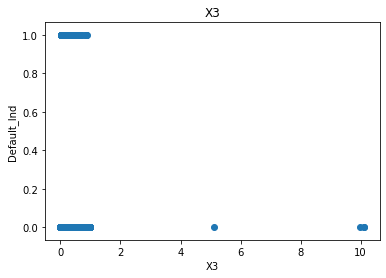

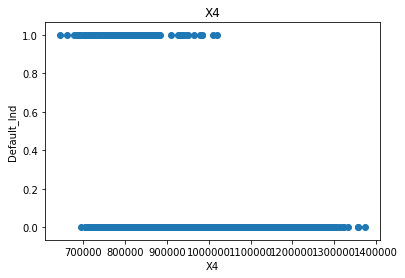

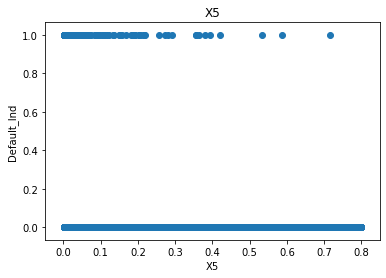

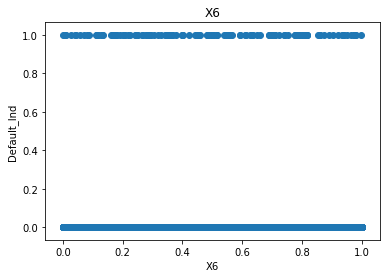

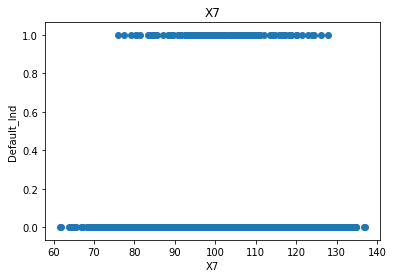

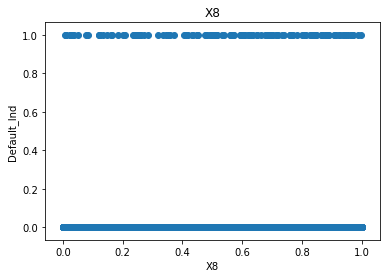

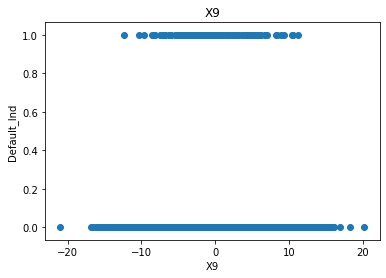

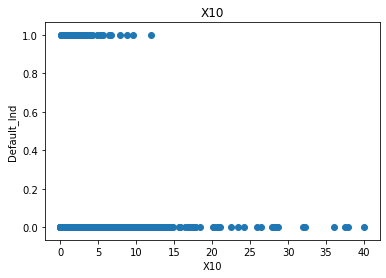

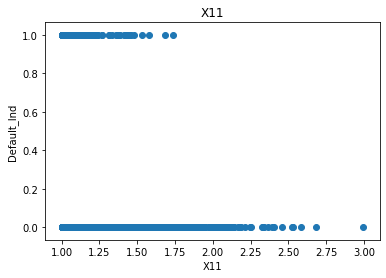

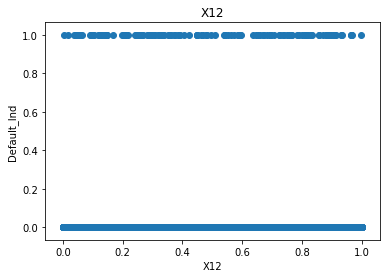

In [15]:
for feature in continuous_feature:
    plt.scatter(temp_continuous_feature[feature],temp_continuous_feature['Default_Ind'])
    plt.xlabel(feature)
    plt.ylabel('Default_Ind')
    plt.title(feature)
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


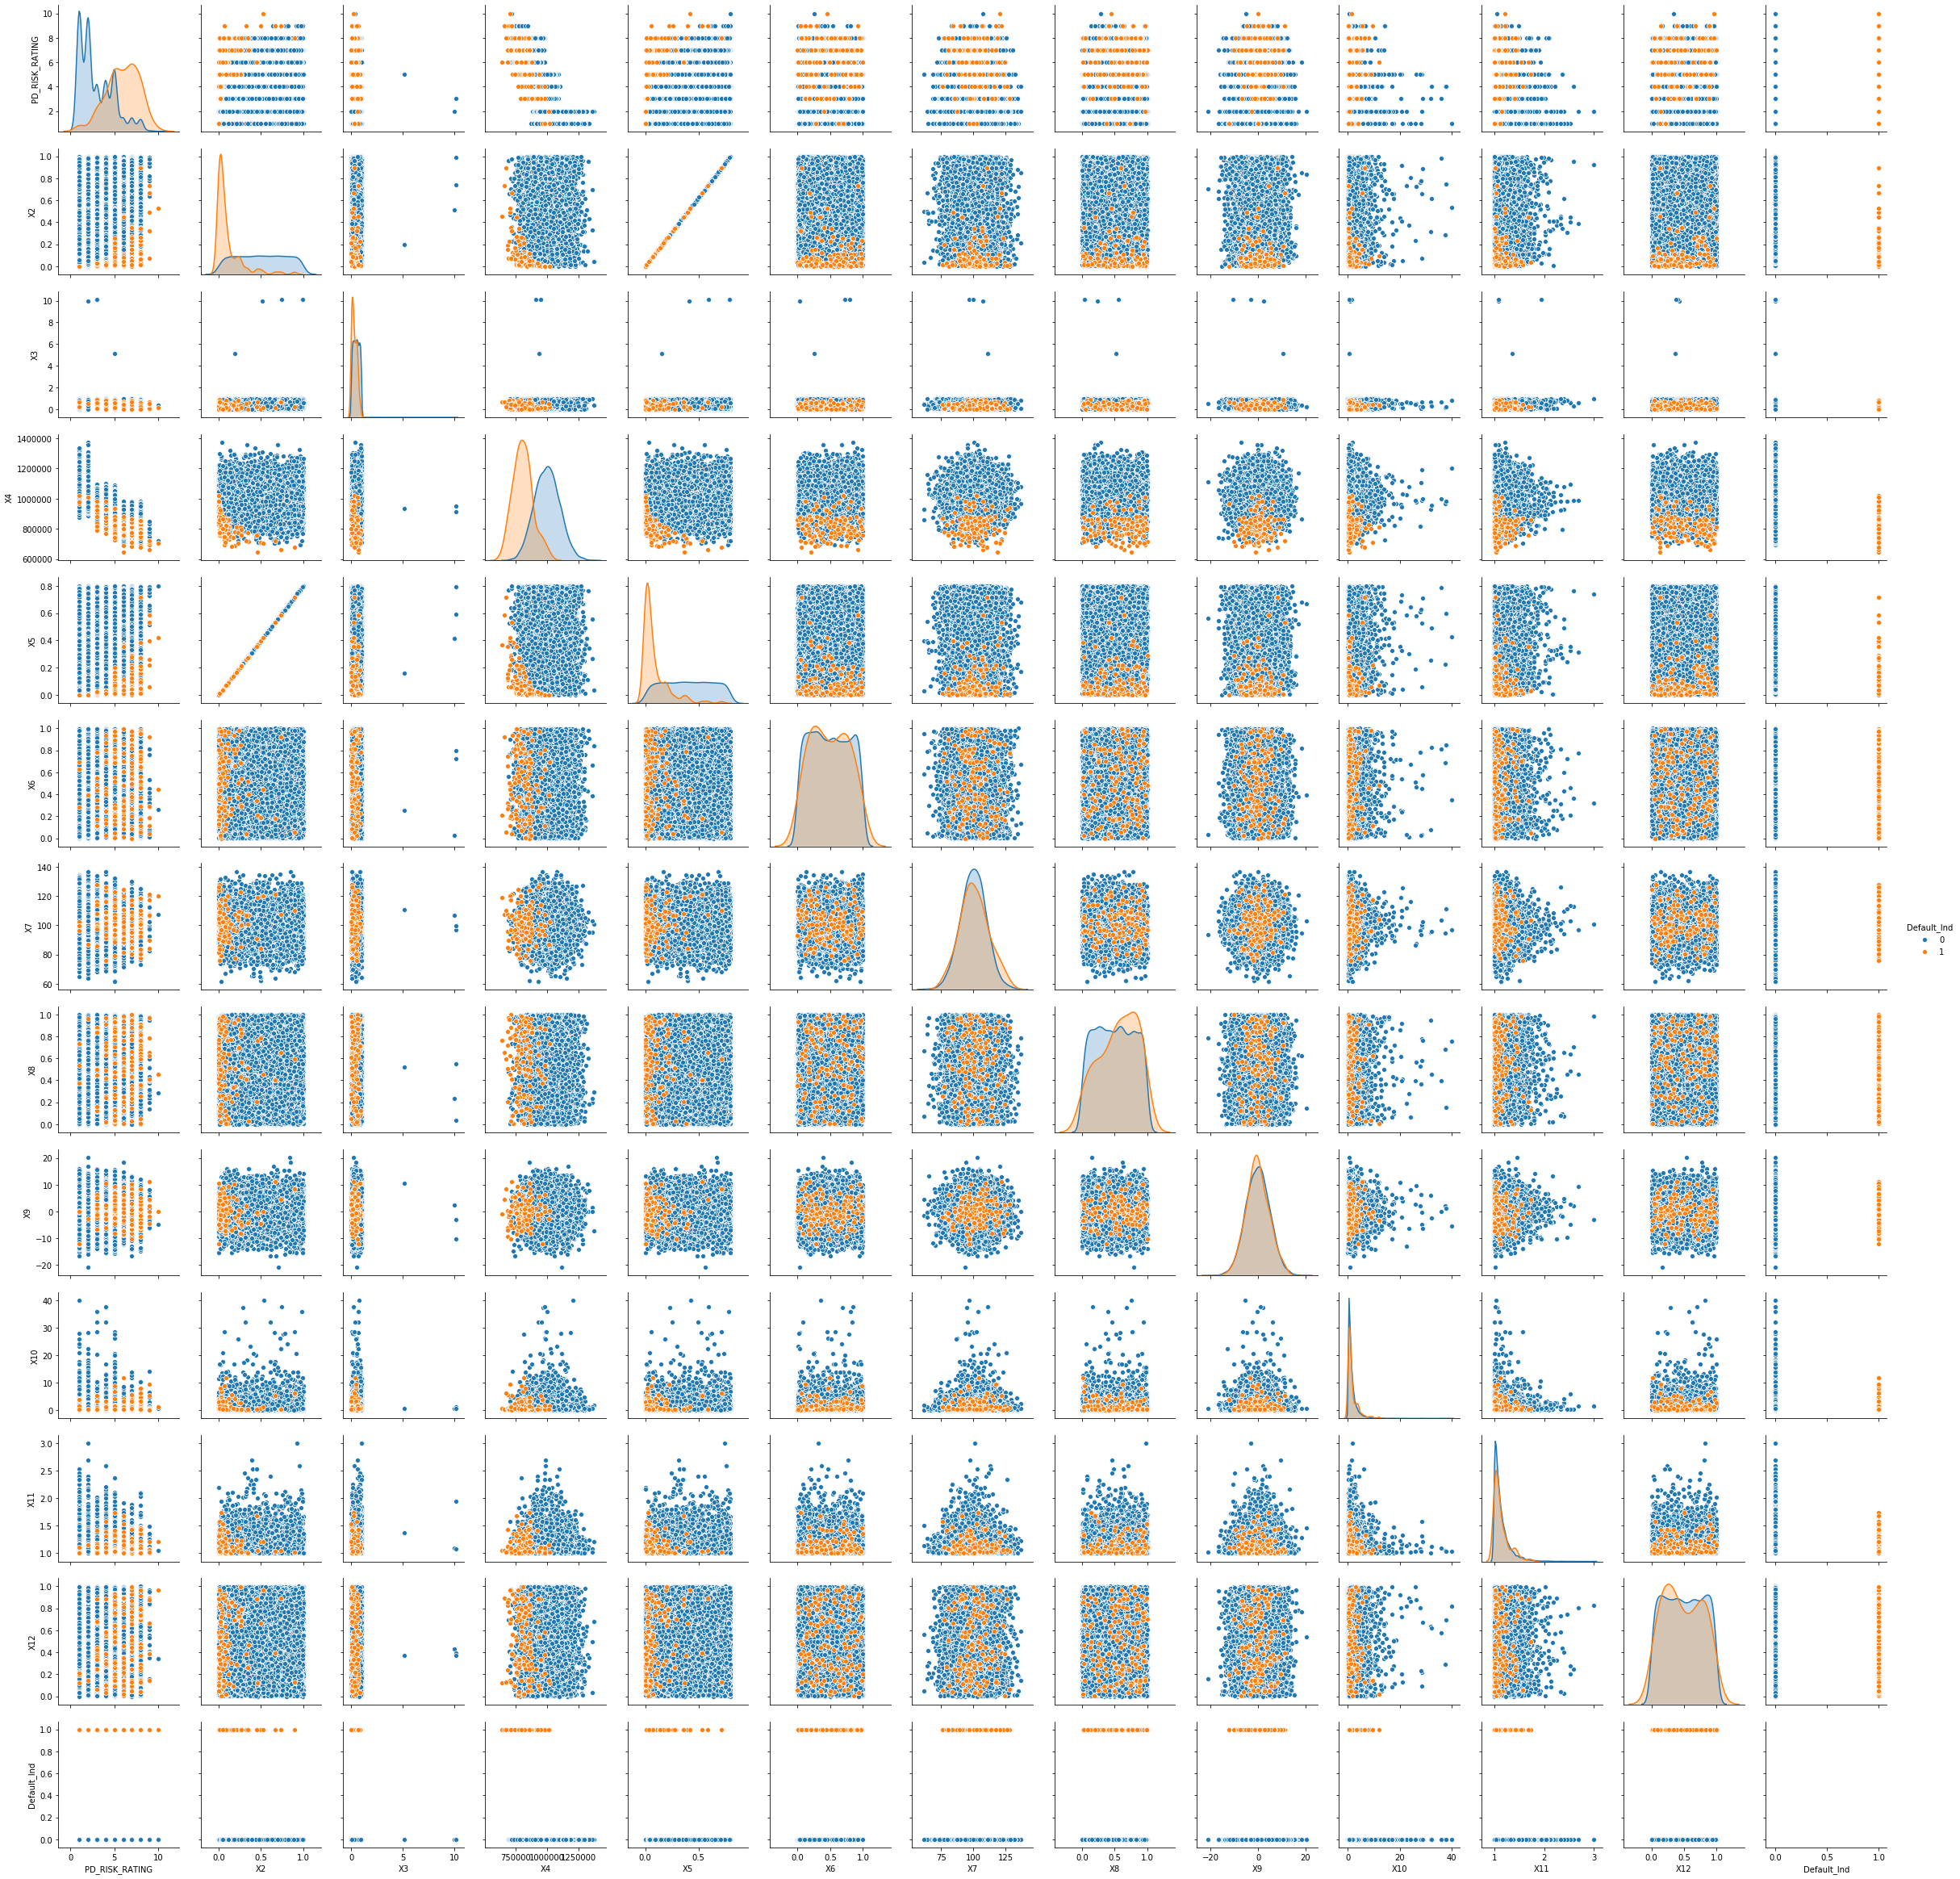

In [16]:
# Pairplot
sns.pairplot(merged, hue = "Default_Ind")

### Outlier detection using boxplots 

#### Outliers are values within every feature that are far away in the distribution and diverges from overall pattern. These values might occur in the dataset due to several reasons including measurement erros, data entry errors, experimental errors, sampling errors, etc. In some cases, these are natural values and not the result of any errors. However, outlier play a key role in influencing the decision making abilities of machine learning models and in most of the cases produce unfavorable results. Hence, outliers needs to be handled appropriately with great care. Although, there are several ways to detect outliers like capping method, z-score, cook's distance, boxplots, etc. We will be using boxplot and interquartile range (IQR) to detect such observations:

#### Any value that is beyond (Q1 -1.5 x IQR) to (Q3 + 1.5 x IQR) can be considered as outlier

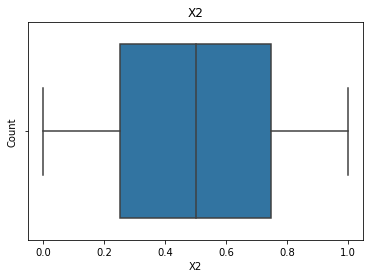

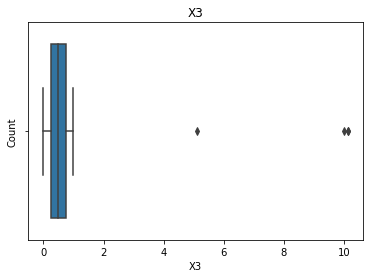

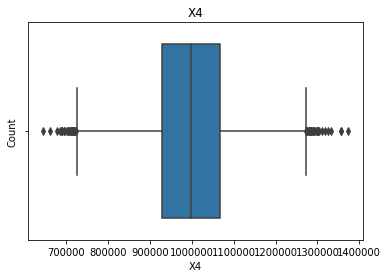

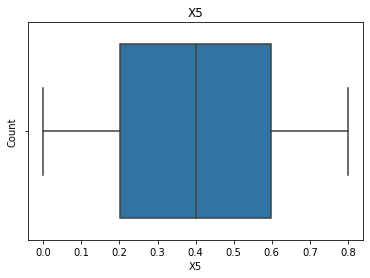

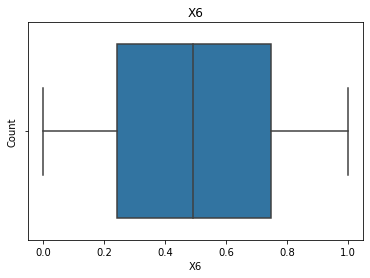

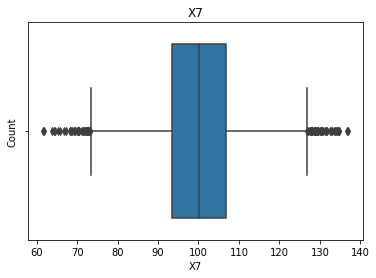

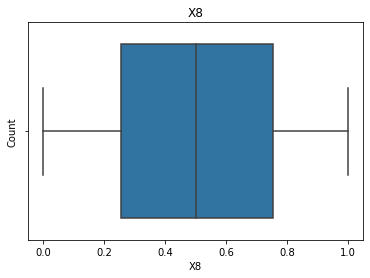

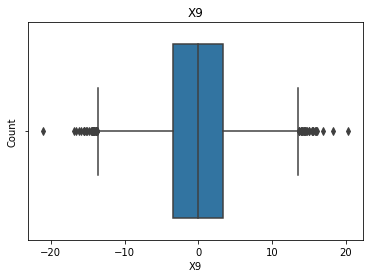

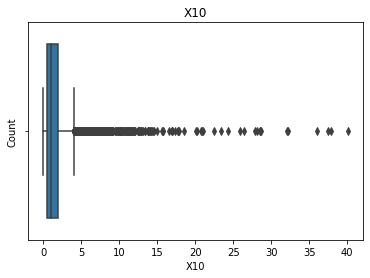

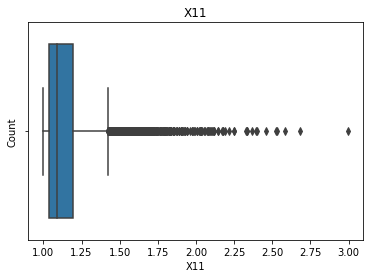

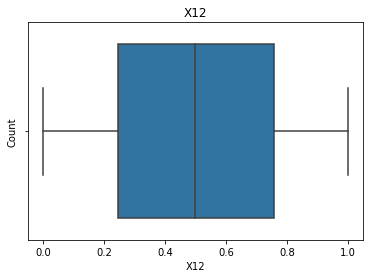

In [17]:
for feature in continuous_feature:
    sns.boxplot(feature,data=merged, hue='Default_Ind')
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

#### From the above boxplots, we can conclude that features 'X3', 'X4', 'X7', 'X9', 'X10', 'X11' have outliers. However, among the suspected outliers, feature 'X3' has extreme observations which appear to be arising due measurement or data entry error (we may also check the descriptive statistics). 'X4', 'X7' and 'X9' have outliers on both the ends. Finally, features 'X10' and 'X11' have values only towards the upper tail and these appear to be coming from sampling error or they might be natural outliers or a combination of both. 

#### We have multiple options to deal with such entries: drop the observations, impute, replace them with some other value from the distribution, etc. We will be handling the outliers in feature engineering phase 

### Descriptive Statistics 

#### Descriptive statistics are summary metrics that quatitatively describe the traits of individual features. 

In [18]:
for feature in continuous_feature:
    temp_continuous_feature=merged.copy()
    print(feature,'\n-------------------------')
    print(temp_continuous_feature[feature].describe(),'\n-------------------------\n')

X2 
-------------------------
count    9000.000000
mean        0.500821
std         0.287893
min         0.000342
25%         0.252151
50%         0.502829
75%         0.748758
max         0.999594
Name: X2, dtype: float64 
-------------------------

X3 
-------------------------
count    10000.000000
mean         0.500171
std          0.334494
min          0.000148
25%          0.250202
50%          0.495737
75%          0.743321
max         10.124300
Name: X3, dtype: float64 
-------------------------

X4 
-------------------------
count    9.000000e+03
mean     9.990384e+05
std      1.007302e+05
min      6.449835e+05
25%      9.293380e+05
50%      9.990395e+05
75%      1.066693e+06
max      1.372729e+06
Name: X4, dtype: float64 
-------------------------

X5 
-------------------------
count    10000.000000
mean         0.400250
std          0.229641
min          0.000273
25%          0.201990
50%          0.401013
75%          0.597996
max          0.799675
Name: X5, dtype: float64 

### Analyzing correlation coefficients 

#### Correlation coefficients allow us to measure the association between various numeric features where values closer to -1 indicate strong negative relationship and values closer to +1 indicate strong positive relationship. However, if we have value very close to zero, does not necessarily mean that there is no correlation between them. It might be possible that they have relationship between them but not linear.  

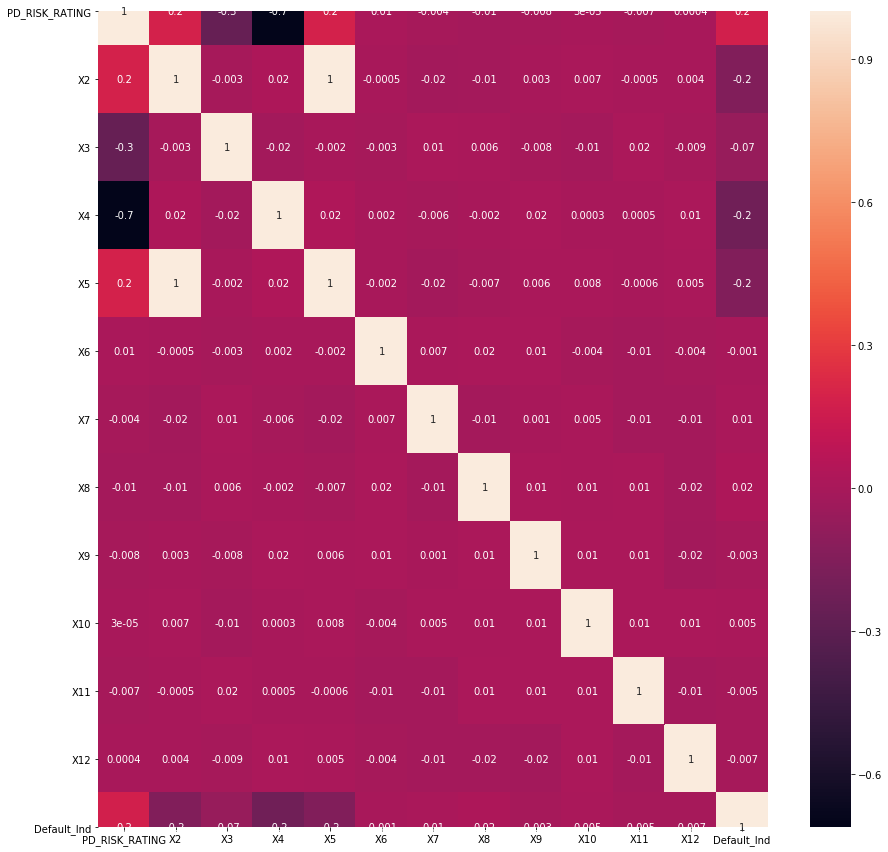

In [19]:
plt.figure(figsize = (15,15))
sns.heatmap(merged.corr(), annot=True,fmt='.1g' )

#### From the above heatmap, we can see that features 'X2' and 'X5' have strong positive relationship between them. Apart from that, the feature 'PD_RISK_RATING' has a good relationship with features 'X2', 'X3', 'X4' and 'X5'. However, since we will be only using features X1 to X15 for modeling and this relationship won't impact the model. When comparing the relationship between the target variable and other independent features, we can infer that features X2, X4 and X5 are good predictors of defaults and have negative relationship with 'Default_Ind'. All other variables in the dataset contribute towards predicting the loan defaults decently.  We can visualize such relationships more clearly with the help of pair plots  

In [20]:
pairplot_df = merged.copy()
#sns.pairplot(pairplot_df, hue='Default_Ind')

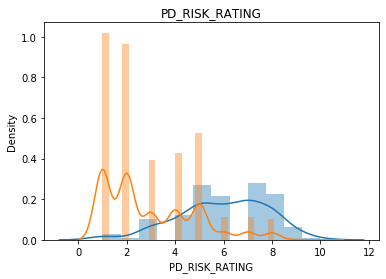

The correlation between PD_RISK_RATING and the TARGET is 0.1760
Median value - Default = 6.0000
Median value - Not Default  =     2.0000


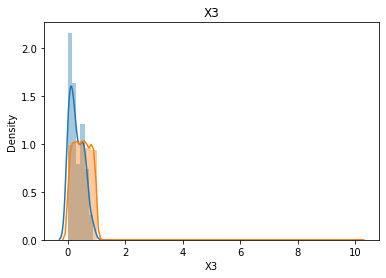

The correlation between X3 and the TARGET is -0.0659
Median value - Default = 0.2434
Median value - Not Default  =     0.4980


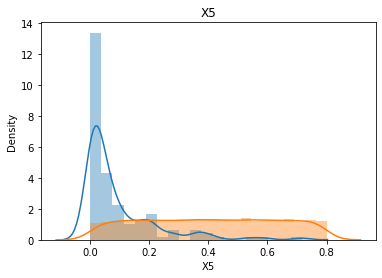

The correlation between X5 and the TARGET is -0.1541
Median value - Default = 0.0378
Median value - Not Default  =     0.4058


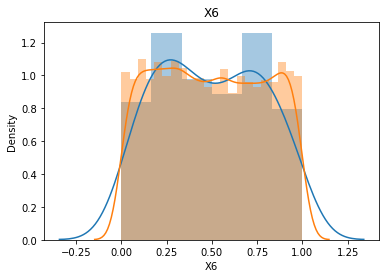

The correlation between X6 and the TARGET is -0.0014
Median value - Default = 0.4890
Median value - Not Default  =     0.4911


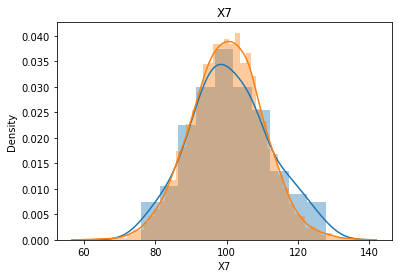

The correlation between X7 and the TARGET is 0.0101
Median value - Default = 100.3857
Median value - Not Default  =     100.1396


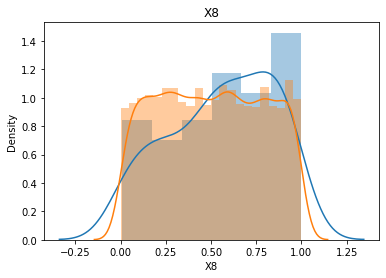

The correlation between X8 and the TARGET is 0.0221
Median value - Default = 0.5951
Median value - Not Default  =     0.5009


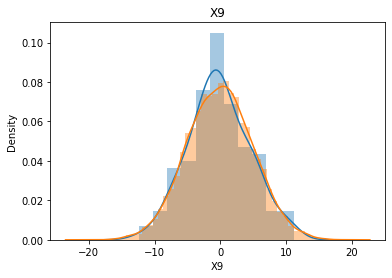

The correlation between X9 and the TARGET is -0.0026
Median value - Default = -0.2513
Median value - Not Default  =     -0.0332


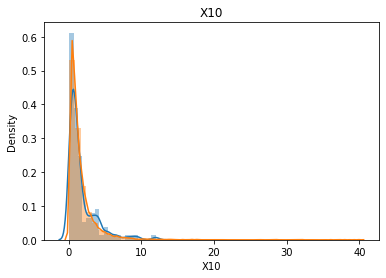

The correlation between X10 and the TARGET is 0.0047
Median value - Default = 1.0385
Median value - Not Default  =     0.9962


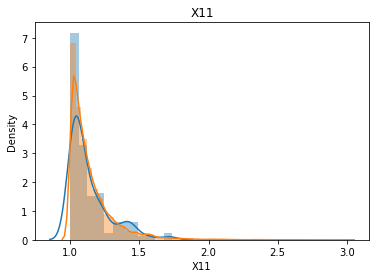

The correlation between X11 and the TARGET is -0.0050
Median value - Default = 1.0811
Median value - Not Default  =     1.0917


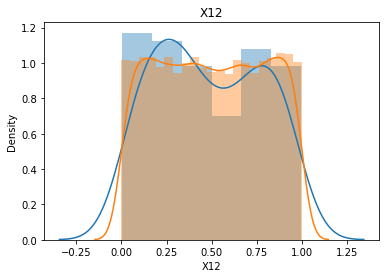

The correlation between X12 and the TARGET is -0.0067
Median value - Default = 0.4491
Median value - Not Default  =     0.4985


In [21]:
for feature in numerical_features:
    if feature in features_with_missing_values or feature == 'Default_Ind':
        continue
    else:
    
        # Calculating medians for defaults vs not defaults
        avg_median_default = merged.loc[merged['Default_Ind'] == 1, feature].median()
        avg_median_not_default = merged.loc[merged['Default_Ind'] == 0, feature].median()
        
        # Calculating correlation between target and the feature
        corr = merged['Default_Ind'].corr(merged[feature])
        
        # Constructing kernal density plots for every feature w.r.t defaults and not defaults
        sns.distplot(merged.loc[merged['Default_Ind'] == 1, feature], label = 'Default_Ind == 1')
        sns.distplot(merged.loc[merged['Default_Ind'] == 0, feature], label = 'Default_Ind == 0')

        plt.xlabel(feature)
        plt.ylabel("Density")
        plt.title(feature)
        plt.show()

        # print out the correlation
        print('The correlation between %s and the TARGET is %0.4f' % (feature, corr))
        # Print out average values
        print('Median value - Default = %0.4f' % avg_median_default)
        print('Median value - Not Default  =     %0.4f' % avg_median_not_default)

#### Distplots are a great way to visualize the distributions of individual features with respect to the target. These plots make use of kernal density estimate (a non-parametric estimate that doesn't assume any underlying distribution of the variable) to show the PDF of the feature and smoothens the noise within the data. These plots give us a better idea about the distribution and unlike histograms, they are not affected by the number of bins. 

#### From the above plots, we can clearly notice the difference in median values of each feature w.r.t to the target class. A notable difference can be found in features X2 and X5, where observations with low values have a high probablity of ending up into the defaulters list. Similarly, we can identify the difference in the median values for other features as well.

### Categorical Features 

In [22]:
# Separating numerical features from the dataset
categorical_features = [feature for feature in merged.columns if merged[feature].dtypes == 'O']
print("Total number of categorical features:  {} ----> {}".format(len(categorical_features),categorical_features))

# Dataset containing numerical values only
merged[categorical_features].head()

Total number of categorical features:  4 ----> ['X1', 'X13', 'X14', 'X15']


X1 X13   X14  X15
0               C&I   C  T982  Yes
1     CRE Permanent   B  X456  Yes
2  CRE Construction   B  T982  Yes
3  CRE Construction   B  T982   No
4  CRE Construction   B  R567  Yes

### Checking rare categorical entries - Total number of distinct categories within each feature 

In [23]:
# Number of distinct categories within each feature.
for feature in categorical_features:
    print('Feature {} ----> number of categories: {}'.format(feature,len(merged[feature].unique())))

Feature X1 ----> number of categories: 3
Feature X13 ----> number of categories: 3
Feature X14 ----> number of categories: 5
Feature X15 ----> number of categories: 2


### Detecting rare categories within each feature 

In [24]:
for feature in categorical_features:
    print('Count of distinct categories within ',feature,'\n',merged[feature].value_counts())

Count of distinct categories within  X1 
 CRE Construction    3375
CRE Permanent       3322
C&I                 3303
Name: X1, dtype: int64
Count of distinct categories within  X13 
 C    3384
B    3346
A    3270
Name: X13, dtype: int64
Count of distinct categories within  X14 
 Y237    2035
Z009    2027
R567    1997
T982    1983
X456    1958
Name: X14, dtype: int64
Count of distinct categories within  X15 
 No     5104
Yes    4896
Name: X15, dtype: int64


#### Based on the above figures we can conclude that there are no rare categories within each categorical feature because each one of them have comparable counts. 

### Categorical features and target variable 

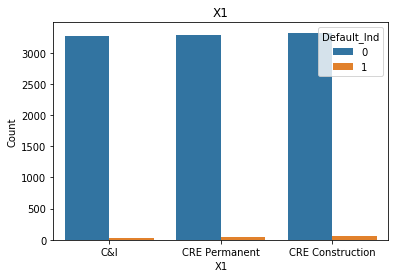

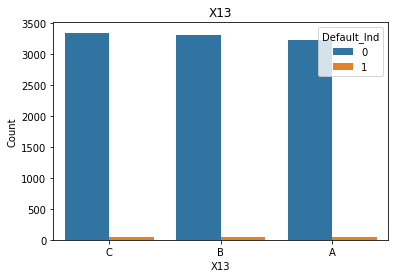

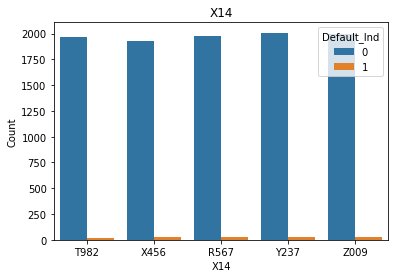

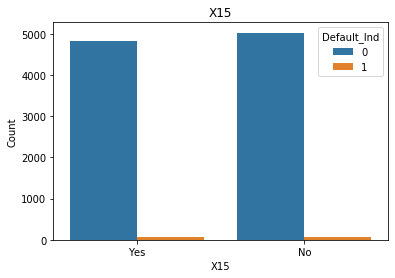

In [25]:
# Constructing count plots group by target
for feature in categorical_features:
    sns.countplot(x = feature, data = merged, hue='Default_Ind')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()
  

#### From the above bar plots, we can see that the proportion of defaulters and non-defaulters within individual category of each feature is comparable

# --------------------------------------------------------------------------------------------------------------

# Feature Engineering 

### Handling missing values in features 'X2' and 'X4'

In [26]:
merged.isnull().sum()

PD_RISK_RATING       0
X1                   0
X2                1000
X3                   0
X4                1000
X5                   0
X6                   0
X7                   0
X8                   0
X9                   0
X10                  0
X11                  0
X12                  0
X13                  0
X14                  0
X15                  0
Default_Ind          0
dtype: int64

#### As we can see from the above figures, features X2 and X4 have 1000 missing values i.e. 10% of the total values in these features  

### Filling the missing values in 'X4' by building a regression model - XG Boost Regression

#### While detecting the missing values, we saw that the count of missing values is sufficient for us to NOT drop the observations with missing values. Also, we analyzed the effect missing values on the target. If we handle such values with imputation, let's say median, out model won't be able to predict accurate results. Since we are having 15.5% and 5.4% of missing values in X2 and X4 ending up in the defaulters list, we need to find something the enables us to fill the missing values more accurately. Hence, the best approach would be building a regressor model to predict the missing values.  

In [27]:
# Copy of merged dataset
final_df = merged.copy()

# Dropping 'X2' because it containes null values that needs to be handled
merged = merged.drop(['X2'],axis=1)


In [28]:
# Removing outliers from the dataset to minimize it's effect on building a regressor model & make accurate predictions for NaN values
features = ['X3','X4','X7','X9','X10','X11']
for feature in features:
    Q1 = merged[feature].quantile(0.25)
    Q3 = merged[feature].quantile(0.75)
    IQR = Q3 - Q1
    # Storing indexes of observation that contains suspected outliers    
    indexHigh = merged[merged[feature] > (Q3 + 1.5*IQR)].index
    indexLow = merged[merged[feature] < (Q1 - 1.5*IQR)].index
    # Dropping the observations from the dataset
    merged.drop(indexHigh , inplace=True)
    merged.drop(indexLow , inplace=True)

#### Treating the subset of data containing missing values as a out-of-sample validation set. This dataset will be feeded to our model once it has been trained and tested 

In [29]:
# Out-of-sample validation set
validation = merged[merged['X4'].isnull()]
validation = validation.drop(['X4'],axis=1)
validation.info(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857 entries, 1 to 9970
Data columns (total 15 columns):
PD_RISK_RATING    857 non-null int64
X1                857 non-null object
X3                857 non-null float64
X5                857 non-null float64
X6                857 non-null float64
X7                857 non-null float64
X8                857 non-null float64
X9                857 non-null float64
X10               857 non-null float64
X11               857 non-null float64
X12               857 non-null float64
X13               857 non-null object
X14               857 non-null object
X15               857 non-null object
Default_Ind       857 non-null int32
dtypes: float64(9), int32(1), int64(1), object(4)
memory usage: 103.8+ KB


In [30]:
# Storing the indexes of missing values
indexesNull = merged[ merged['X4'].isnull()].index
# Dropping observations with missing values
merged.drop(indexesNull , inplace=True)

merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7625 entries, 0 to 9998
Data columns (total 16 columns):
PD_RISK_RATING    7625 non-null int64
X1                7625 non-null object
X3                7625 non-null float64
X4                7625 non-null float64
X5                7625 non-null float64
X6                7625 non-null float64
X7                7625 non-null float64
X8                7625 non-null float64
X9                7625 non-null float64
X10               7625 non-null float64
X11               7625 non-null float64
X12               7625 non-null float64
X13               7625 non-null object
X14               7625 non-null object
X15               7625 non-null object
Default_Ind       7625 non-null int32
dtypes: float64(10), int32(1), int64(1), object(4)
memory usage: 982.9+ KB


In [31]:
# Categorical feature encoding using get_dummies from pandas
for feature in categorical_features: 
    dummyFeature = pd.get_dummies(merged[feature]) 
    merged = pd.concat([merged,dummyFeature],axis=1)
    merged = merged.drop(feature,axis=1)
merged.head(1)

PD_RISK_RATING        X3           X4        X5        X6          X7  \
0               2  0.795355  1156188.606  0.090963  0.963879  120.606137   

         X8       X9       X10       X11  ...  A  B  C  R567  T982  X456  \
0  0.966454 -6.88499  0.195105  1.093855  ...  0  0  1     0     1     0   

   Y237  Z009  No  Yes  
0     0     0   0    1  

[1 rows x 25 columns]

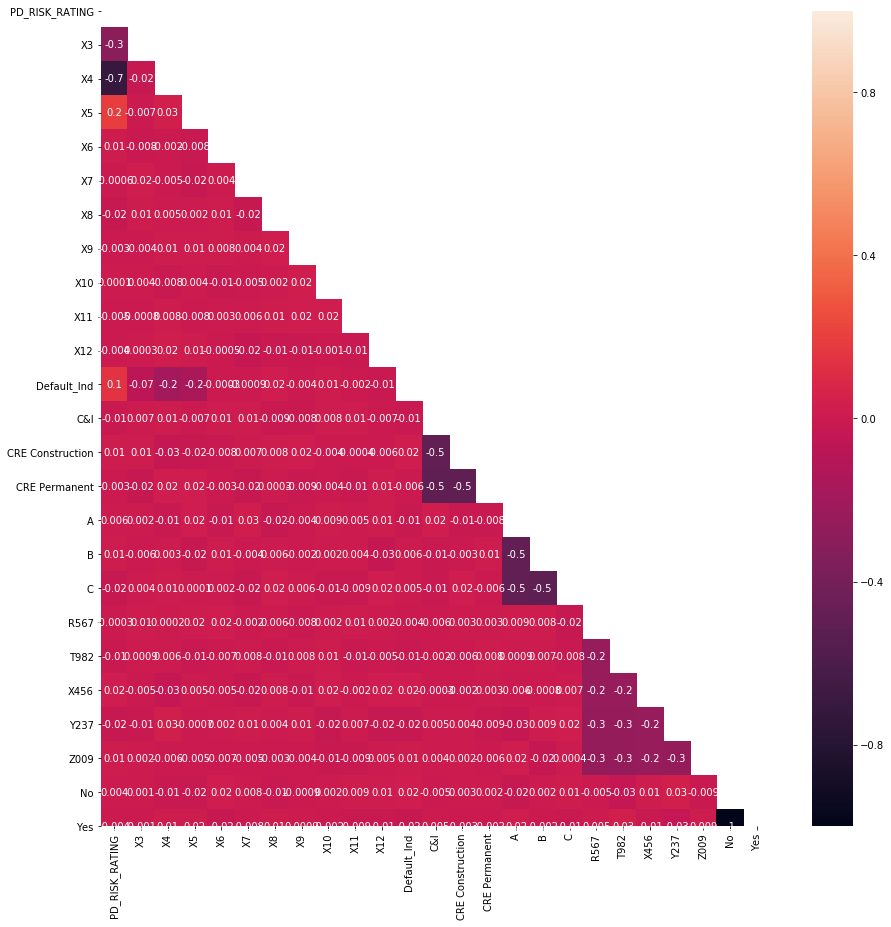

In [32]:
corr_df = merged.copy()
plt.figure(figsize = (15,15))
matrix = np.triu(corr_df.corr())
sns.heatmap(corr_df.corr(),mask=matrix, annot=True,fmt='.1g' )

In [33]:
X = merged.copy()
X=X.drop(['X4'],axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7625 entries, 0 to 9998
Data columns (total 24 columns):
PD_RISK_RATING      7625 non-null int64
X3                  7625 non-null float64
X5                  7625 non-null float64
X6                  7625 non-null float64
X7                  7625 non-null float64
X8                  7625 non-null float64
X9                  7625 non-null float64
X10                 7625 non-null float64
X11                 7625 non-null float64
X12                 7625 non-null float64
Default_Ind         7625 non-null int32
C&I                 7625 non-null uint8
CRE Construction    7625 non-null uint8
CRE Permanent       7625 non-null uint8
A                   7625 non-null uint8
B                   7625 non-null uint8
C                   7625 non-null uint8
R567                7625 non-null uint8
T982                7625 non-null uint8
X456                7625 non-null uint8
Y237                7625 non-null uint8
Z009                7625 non-null u

In [34]:
y = merged['X4']
y.head()

0    1.156189e+06
2    1.046683e+06
3    1.085325e+06
4    1.051379e+06
5    7.965421e+05
Name: X4, dtype: float64

In [35]:
# Train-Test split (80:20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Standardizing the features using Standard Scalar
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)
X_train.head(5)

<IPython.core.display.Javascript object>

PD_RISK_RATING        X3        X5        X6        X7        X8        X9  \
0        1.044279  0.663678 -0.365712 -0.720911 -1.190369  1.168046 -1.157015   
1       -1.043937 -0.808204 -1.003198  0.672168 -0.019178  1.180717 -2.468560   
2       -1.043937 -0.035940 -0.121573  1.478034  2.648600  1.078590  0.050233   
3        0.000171 -0.546222 -0.585293 -0.034858  0.938391  1.510383  0.799313   
4        2.088387 -1.001478 -1.516548  1.329150 -0.897334  0.251863 -1.149606   

        X10       X11       X12  ...         A         B         C      R567  \
0  2.338822 -0.244127 -1.406266  ... -0.692204 -0.713289  1.396831  1.988799   
1 -0.701921  0.898231 -1.116147  ... -0.692204  1.401957 -0.715906 -0.502816   
2 -0.671534 -0.765121  1.077287  ...  1.444661 -0.713289 -0.715906 -0.502816   
3 -0.569902 -0.577520 -0.418471  ... -0.692204 -0.713289  1.396831 -0.502816   
4 -0.572350 -0.186834 -0.550352  ... -0.692204  1.401957 -0.715906 -0.502816   

       T982      X456      Y237      Z009        No       Yes  
0 -0.501792 -0.485096 -0.505885 -0.504351  0.991186 -0.991186  
1 -0.501792 -0.485096  1.976735 -0.504351  0.991186 -0.991186  
2 -0.501792 -0.485096  1.976735 -0.504351  0.991186 -0.991186  
3 -0.501792 -0.485096  1.976735 -0.504351  0.991186 -0.991186  
4 -0.501792 -0.485096 -0.505885  1.982747 -1.008892  1.008892  

[5 rows x 24 columns]

In [36]:
# Building an XG Boost regression model
xgbMissing = xgboost.XGBRegressor()
xgbMissing.fit(X_train,y_train)
y_pred_missing = xgbMissing.predict(X_test)

# Checking the mean squared error from the base model
mean_squared_error(y_test, y_pred_missing)

3260140964.6044374

In [37]:
# Hyperparameter optimization using Randomized Search CV 
params = {
    "learning_rate" : [0.05,0.10,0.15,0.20],
    "max_depth" : [3,6,8,12,15],
    "min_child_weight" : [3,5,7],
    "gamma": [0.0,0.1,0.2,0.3,0.4],
    "colsample_bytree" : [0.3,0.6,0.7]
}

classifierMissing = xgboost.XGBRegressor()
random_search_missing = RandomizedSearchCV(classifierMissing, param_distributions=params,n_iter=5,scoring='neg_mean_squared_error',n_jobs=-1,cv=5,verbose=3)
random_search_missing.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   24.1s finished


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          random_state=None, reg_alpha=None,
                                          reg_lambda=None,
                                          scale_pos_we

In [38]:
# Obtaining the best estimator model parameters from randomized search cross validation
random_search_missing.best_estimator_

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.15, max_delta_step=0, max_depth=3,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [39]:
#Building the final regression model

final_missing = xgboost.XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.15, max_delta_step=0, max_depth=3,
             min_child_weight=5,  monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)
final_missing.fit(X_train,y_train)
y_pred_missing_optimized = final_missing.predict(X_test)
mean_squared_error(y_test, y_pred_missing_optimized)

2948323244.286988

In [40]:
# Encoding the categorical features within the out-of-sample validation set
for feature in categorical_features: 
    dummyFeature = pd.get_dummies(validation[feature]) 
    validation = pd.concat([validation,dummyFeature],axis=1)
    validation = validation.drop(feature,axis=1)
validation.head(1)

PD_RISK_RATING        X3       X5        X6          X7        X8  \
1               4  0.364232  0.49784  0.606212  109.621719  0.440733   

          X9       X10       X11       X12  ...  A  B  C  R567  T982  X456  \
1 -10.010214  1.600637  1.146797  0.857632  ...  0  1  0     0     0     1   

   Y237  Z009  No  Yes  
1     0     0   0    1  

[1 rows x 24 columns]

In [41]:
# Predicting the missing values by feeding the validation set to our optimized model
y_pred_OOB = final_missing.predict(validation)

# Replacing the missing values in original dataset with predicted values
for i in range(0,len(y_pred_OOB)):
    final_df.loc[final_df['X4'].isnull(), 'X4'] = y_pred_OOB[i] 
    
# Checking for missing values again
final_df.isnull().any()

PD_RISK_RATING    False
X1                False
X2                 True
X3                False
X4                False
X5                False
X6                False
X7                False
X8                False
X9                False
X10               False
X11               False
X12               False
X13               False
X14               False
X15               False
Default_Ind       False
dtype: bool

### Handling missing values in 'X2' 

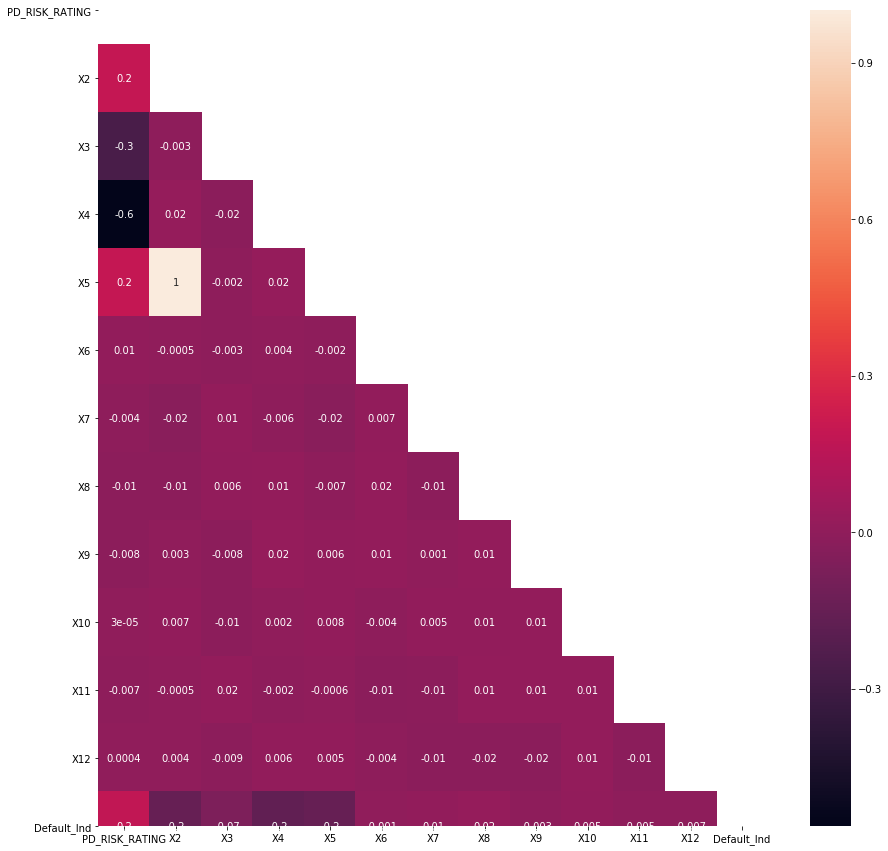

In [42]:
plt.figure(figsize = (15,15))
matrix = np.triu(final_df.corr())
sns.heatmap(final_df.corr(),mask=matrix, annot=True,fmt='.1g' )

#### From the above heatmap, it can be clearly seen that X2 is highly correlated with X5. We also visualized the relationship using the pairplot. Therefore, only one feature is sufficient enough to predict the target and dropping any one would be fine. Since, X2 has missing values in it, we will drop the feature.

In [43]:
# There is a high correlation between independent features 'X2' and 'X5'. One is sufficient to predict the default
# We can discard 'X2' from the dataframe since it has NaN values

final_df = final_df.drop(['X2'],axis=1)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 16 columns):
PD_RISK_RATING    10000 non-null int64
X1                10000 non-null object
X3                10000 non-null float64
X4                10000 non-null float64
X5                10000 non-null float64
X6                10000 non-null float64
X7                10000 non-null float64
X8                10000 non-null float64
X9                10000 non-null float64
X10               10000 non-null float64
X11               10000 non-null float64
X12               10000 non-null float64
X13               10000 non-null object
X14               10000 non-null object
X15               10000 non-null object
Default_Ind       10000 non-null int32
dtypes: float64(10), int32(1), int64(1), object(4)
memory usage: 1.3+ MB


### Handling suspected outliers

#### For handling the outliers,instead of just dropping them, we will be replacing the entries with extreme values from the distribution as an attempt to make the observations as a part of the distribution, yet being different from most the values. Since, we are dealing with financial data, data points towards the right tail of the distributions are expected and these values have a decent chance of being a natural outlier. Another possibility is, that the sample chosen from the population unknowingly ends up having values within specific range.

#### Consider an example where we are measuring heights of every individual entering the stadium for a NBA match. In this case, if we measure the height of NBA players along with the spectators and plot a distribution of our observations, we might definitely end up with the players height at the extreme ends. Similarly, we observe such behaviour with financial data as well.Because we are having just 10000 records with only 129 obligors in it, we cannot afford to lose any information from our model. It will be a great problem for our model to learn if we drop observations with target as defaulter and end up with limited data regarding defaulters. Hence, we replace it with values at the extreme ends of the distribution



In [44]:
# As we saw during exploratory data analysis, features'X3','X4','X7','X9','X10' and 'X11' have outliers in them
features_with_outliers = ['X3','X4','X7','X9','X10','X11']
for feature in features_with_outliers:
    Q1 = final_df[feature].quantile(0.25)
    Q3 = final_df[feature].quantile(0.75)
    IQR = Q3 - Q1    
    
    # Replacing outliers at the right hand side of the distribution with Q3 + 1.5*IQR
    final_df.loc[final_df[feature] > (Q3 + 1.5*IQR), feature ] = Q3 + 1.5*IQR
    # Replacing outliers at the left hand side of the distribution with Q1 - 1.5*IQR
    final_df.loc[final_df[feature] < (Q1 - 1.5*IQR), feature ] = Q1 - 1.5*IQR

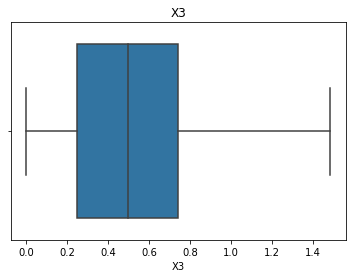

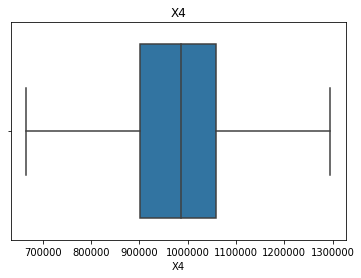

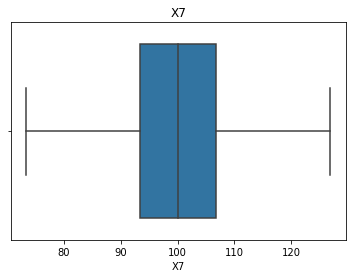

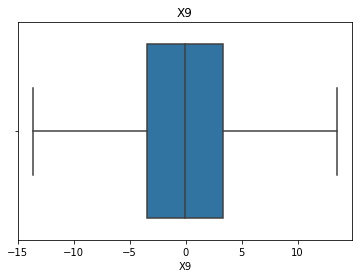

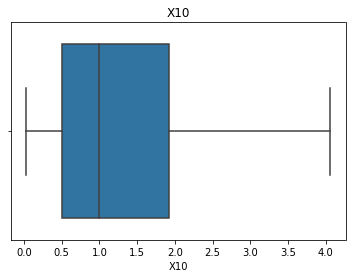

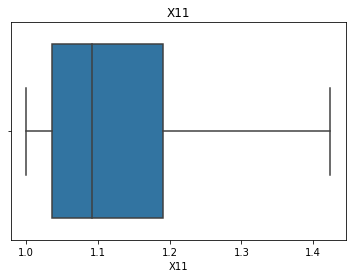

In [45]:
for feature in features_with_outliers:
    temp_continuous_feature=final_df.copy()
    sns.boxplot(feature,data=temp_continuous_feature)
    plt.xlabel(feature)
    plt.title(feature)
    plt.show()

#### Outliers and missing values has been handled successfully!  

### Categorical Feature Encoding 

#### In our dataset, we have 4 categorical variables. However, the machine only understands numbers and therefore, converting the categorical values into numerical values is an essential step in machine learning. 

#### There are several approaches to do so and choosing the appropriate approach, depends on the nature of the categorical value. We have different techniques for ordinal and nominal variables such one hot encoding, mean encoding, target driven encoding, etc. However, since we do not know if the feature is ordinal or nominal and as we saw during exploratory data analysis, the proportion of defaulters and non-defaulters within individual category of each feature have comparable ratios, the safest approach would be using one hot encoding with dummy variable trap. 

#### We will be using get_dummies() from pandas to execute one hot encoding and set the 'drop_first' parameter in get_dummies() as 'True', to set up the dummy variable trap.

In [46]:
final = final_df.copy()
categorical_features = [feature for feature in final.columns if final[feature].dtypes == 'O']
for feature in categorical_features: 
    dummyFeature = pd.get_dummies(final[feature], prefix= feature, drop_first=True) 
    final = pd.concat([final,dummyFeature],axis=1)
    final = final.drop(feature,axis=1)
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 21 columns):
PD_RISK_RATING         10000 non-null int64
X3                     10000 non-null float64
X4                     10000 non-null float64
X5                     10000 non-null float64
X6                     10000 non-null float64
X7                     10000 non-null float64
X8                     10000 non-null float64
X9                     10000 non-null float64
X10                    10000 non-null float64
X11                    10000 non-null float64
X12                    10000 non-null float64
Default_Ind            10000 non-null int32
X1_CRE Construction    10000 non-null uint8
X1_CRE Permanent       10000 non-null uint8
X13_B                  10000 non-null uint8
X13_C                  10000 non-null uint8
X14_T982               10000 non-null uint8
X14_X456               10000 non-null uint8
X14_Y237               10000 non-null uint8
X14_Z009               10000 non-nul

# --------------------------------------------------------------------------------------------------------------

## Train-Test Split & Feature Scaling

### (We will be dropping the 'PD_RISK_RATING' from the dataset as per the requirements laid out in the specifications document)

In [47]:
final=final.drop(['PD_RISK_RATING'],axis=1)
final.head(5)

X3            X4        X5        X6          X7        X8  \
0  0.795355  1.156189e+06  0.090963  0.963879  120.606137  0.966454   
1  0.364232  7.947298e+05  0.497840  0.606212  109.621719  0.440733   
2  0.821238  1.046683e+06  0.487420  0.296746   94.520306  0.007491   
3  0.613073  1.085325e+06  0.498704  0.641079   94.933871  0.910976   
4  0.709228  1.051379e+06  0.688732  0.339430  106.331848  0.939269   

          X9       X10       X11       X12  Default_Ind  X1_CRE Construction  \
0  -6.884990  0.195105  1.093855  0.890361            0                    0   
1 -10.010214  1.600637  1.146797  0.857632            0                    0   
2  10.726384  0.434792  1.050520  0.150828            0                    1   
3   0.476127  0.341299  1.011261  0.120293            0                    1   
4   0.251195  0.967834  1.002241  0.329663            0                    1   

   X1_CRE Permanent  X13_B  X13_C  X14_T982  X14_X456  X14_Y237  X14_Z009  \
0                 0      0      1         1         0         0         0   
1                 1      1      0         0         1         0         0   
2                 0      1      0         1         0         0         0   
3                 0      1      0         1         0         0         0   
4                 0      1      0         0         0         0         0   

   X15_Yes  
0        1  
1        1  
2        1  
3        0  
4        1

In [48]:
# We will separate the target variable from the set of independent variable
X = final.copy()
X=X.drop(['Default_Ind'],axis=1)
y = final['Default_Ind']
print(X.info())
print(y.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 19 columns):
X3                     10000 non-null float64
X4                     10000 non-null float64
X5                     10000 non-null float64
X6                     10000 non-null float64
X7                     10000 non-null float64
X8                     10000 non-null float64
X9                     10000 non-null float64
X10                    10000 non-null float64
X11                    10000 non-null float64
X12                    10000 non-null float64
X1_CRE Construction    10000 non-null uint8
X1_CRE Permanent       10000 non-null uint8
X13_B                  10000 non-null uint8
X13_C                  10000 non-null uint8
X14_T982               10000 non-null uint8
X14_X456               10000 non-null uint8
X14_Y237               10000 non-null uint8
X14_Z009               10000 non-null uint8
X15_Yes                10000 non-null uint8
dtypes: float64(10), uint8(9)
memory

#### Splitting the data into train and test datasets using stratification and then, we will be using StandardScalar() to normalize the range of independent features of the data

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0,stratify=y)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)
X_train.info()

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 19 columns):
X3                     7000 non-null float64
X4                     7000 non-null float64
X5                     7000 non-null float64
X6                     7000 non-null float64
X7                     7000 non-null float64
X8                     7000 non-null float64
X9                     7000 non-null float64
X10                    7000 non-null float64
X11                    7000 non-null float64
X12                    7000 non-null float64
X1_CRE Construction    7000 non-null float64
X1_CRE Permanent       7000 non-null float64
X13_B                  7000 non-null float64
X13_C                  7000 non-null float64
X14_T982               7000 non-null float64
X14_X456               7000 non-null float64
X14_Y237               7000 non-null float64
X14_Z009               7000 non-null float64
X15_Yes                7000 non-null float64
dtypes: float64(19)
memory usage: 1.0 

# --------------------------------------------------------------------------------------------------------------

## Feature Selection
#### Feature selection is an important step in machine learning where we try to utilize the features into model training that have maximum impact on prediction. Having irrelevant features in training can significantly decrease the performance of the model. 

#### As we saw earlier, feature 'X2' had missing values in it and was highly correlated with feature 'X5'. In such cases where we have high correlation between independent features, any one of them is sufficient for prediction. Furthermore, while converting the categorical features into numerical features during encoding, we saw that for every category in the feature, a dummy variable was created. Consider the below example: a categorical feature having 3 categories -> A,B and C. If we use one hot encoding, it will convert these categories into distinct features with values 1 and 0 for identification. However, in order to identify (let's say 'C'), it is sufficient to have 0 in variables A and B. Therefore, in order to remove redunduncy from our dataset, we made the used of dummy trap to restrict the formulation of features to 'N-1' instead of 'N' (N -> number of categories within each feature). Apart from such features, we saw the heatmap of the correlations coefficients and we can intially infer from the exploratory data analysis that, almost every other feature correlates with the target. Their correlation coefficient values are comparable and thus, we will proceed ahead with feature selection in two stages. Initially, we will proceed ahead the the features we have, and build models, and later incorporate dimensionality reduction techniques such as principle component analysis (PCA) in order to analyze the variation around the data contribution of each feature in prediction. If converting or flattening the data into lower dimension improves the performance of the model, we will proceed ahead, otherwise, we will stick to our finalized model. 

# --------------------------------------------------------------------------------------------------------------

## Model building 


#### Selecting the right machine learning algorithm plays a pivotal role in determining the success of any machine learning project. In case of imbalanced dataset and sensitive data, utmost care needs to be taken will finalizing the correct machine learning model. Also, we need to determine the correct evaluation metric to be considered for comparing and select the right ml algorithm. Let's us try to visualize the pairplot  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


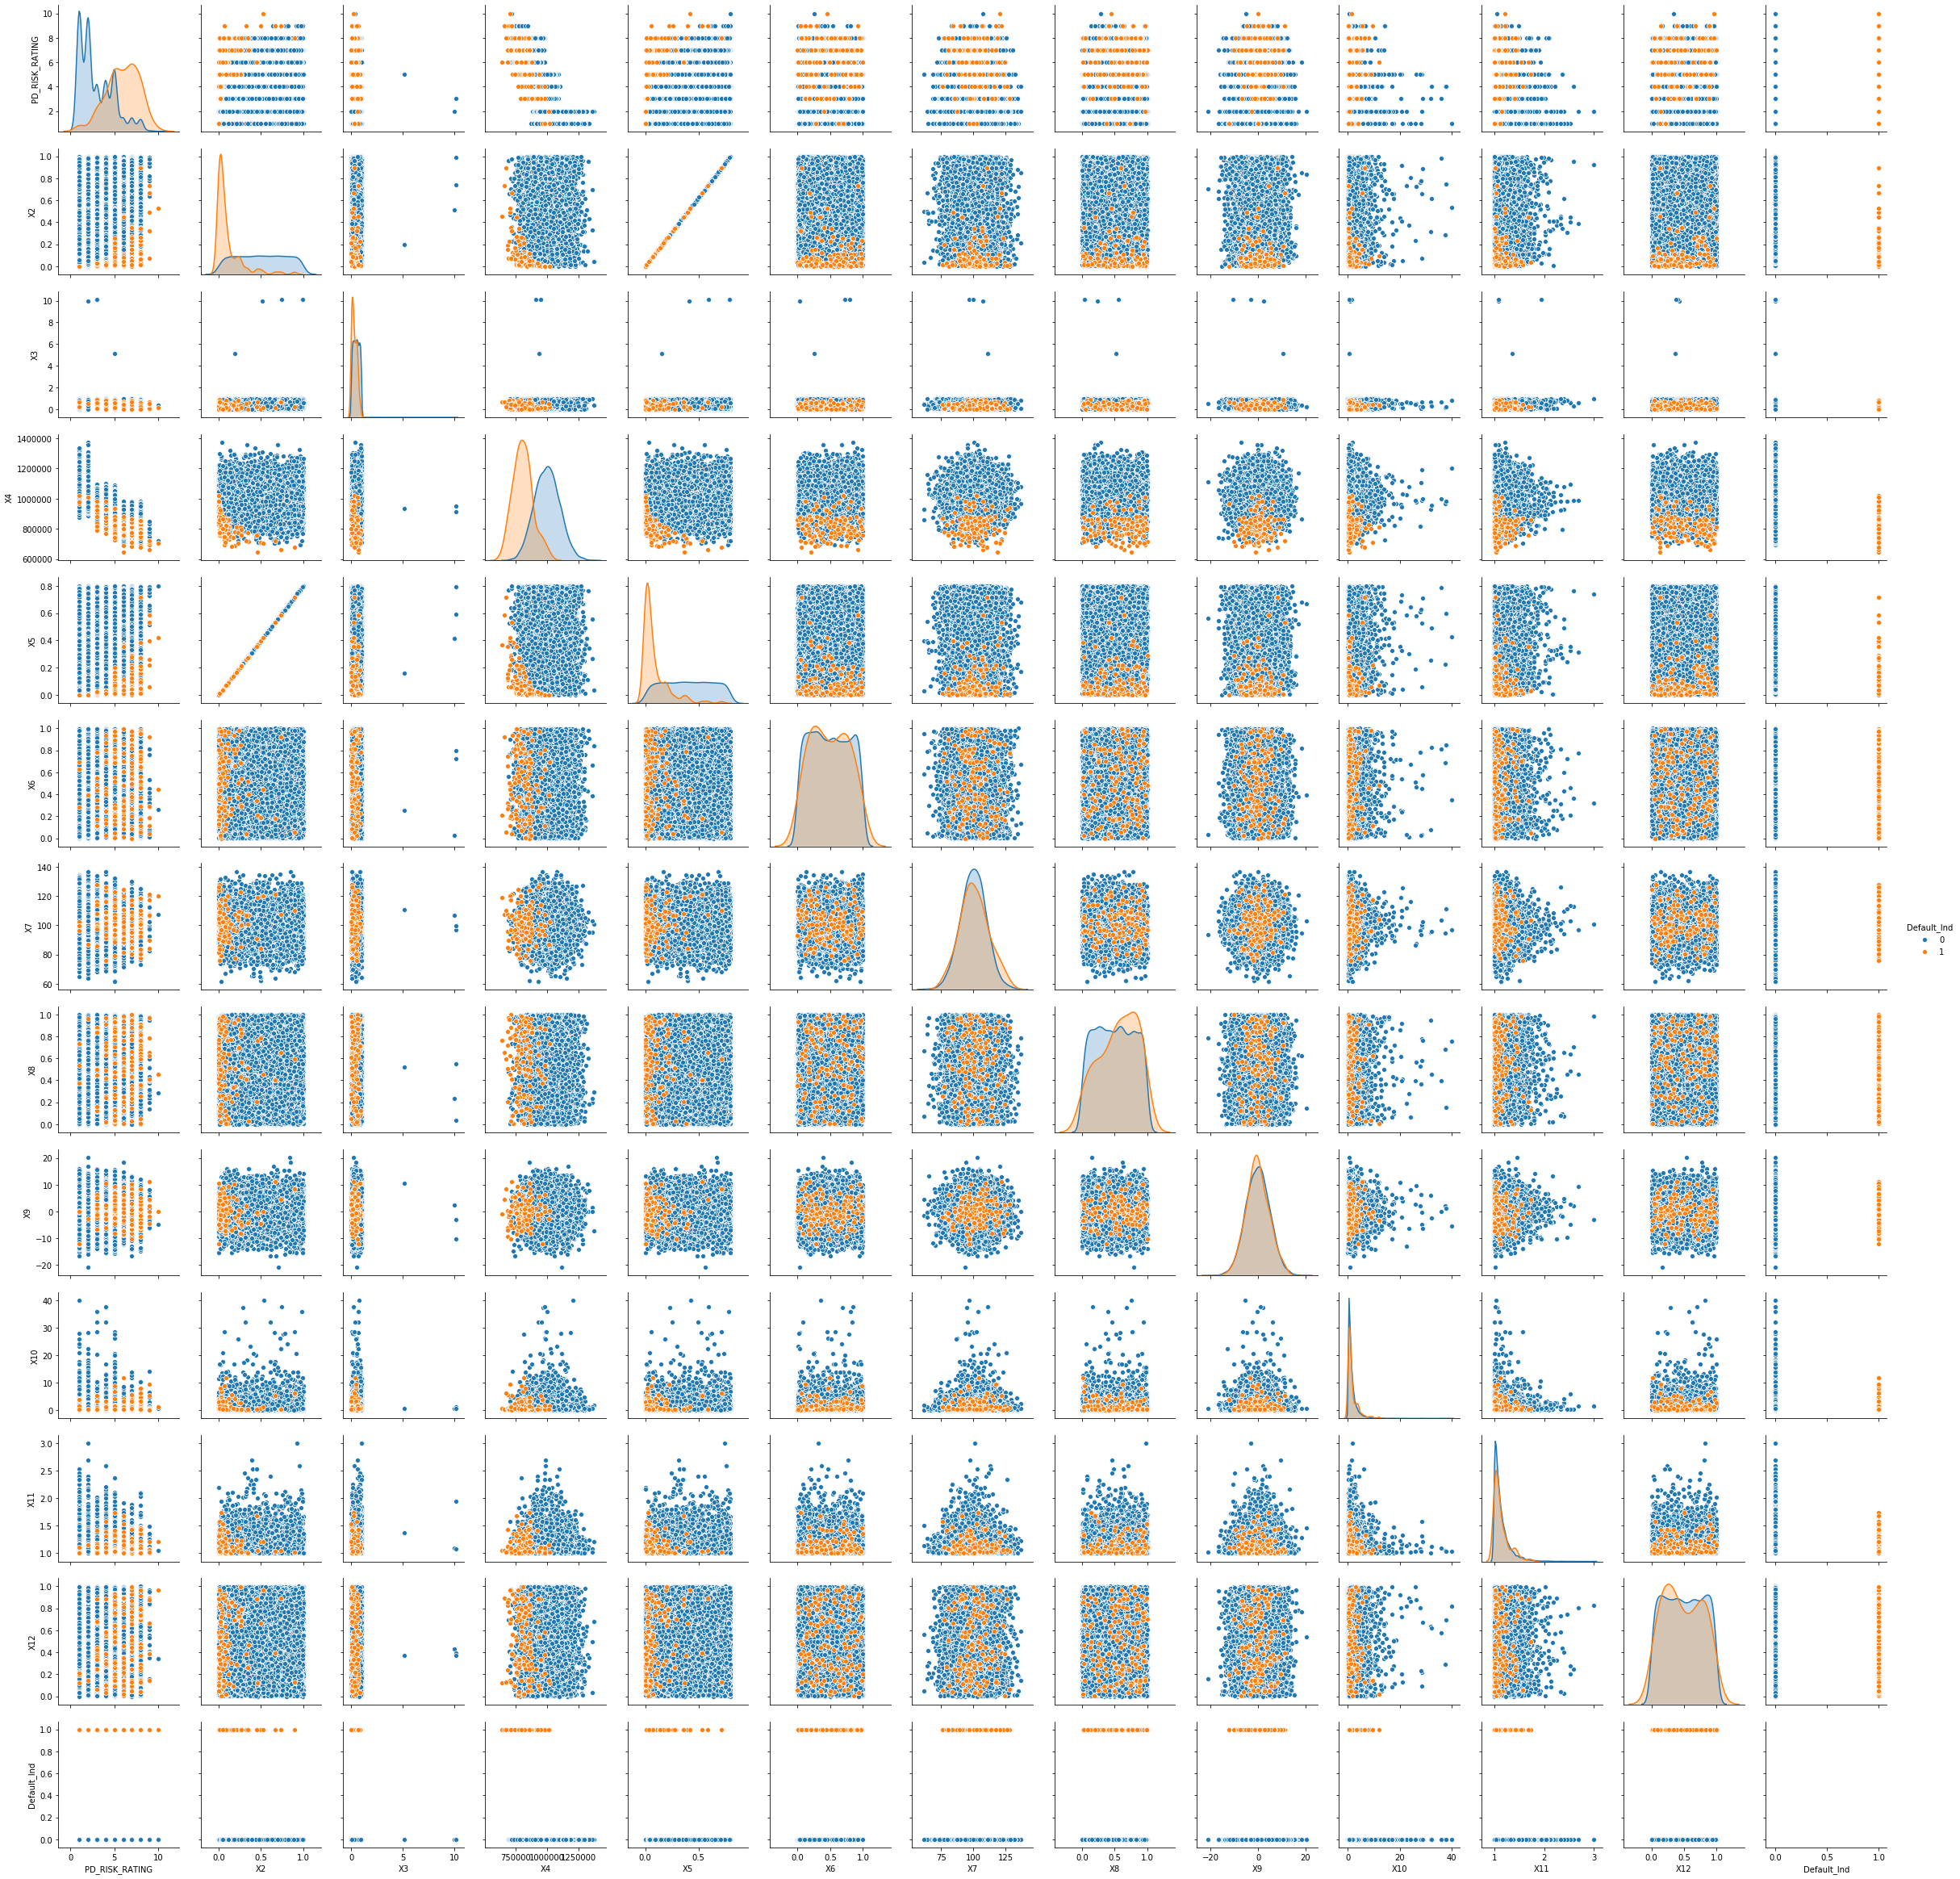

In [50]:
sns.pairplot(pairplot_df, hue='Default_Ind')

#### We can clearly see from the above visuals that there is too much overlapping among the datapoints between the features and there is no specific margin that allows us to separate the defaulters from the non-defaulters. For such cases, linear models usually don't work and hence, an initial assumption would be that logistic regression wont be able to perform well. Similarly, for such kind of problems, naive bayes algorithm usually doesn't perform well, as it treats every feature as an independent predictor. For instances where we do not have a clear separation or perfect split, trees based algorithms work well. We have ensemble techniques like bagging and boosting that combine multiple tree based algorithms to make predictions. Such algorithms solves the problems efficiently as compared to the traditional tree based models and help us to prevent the model from overfitting.  We will be using Random Forests and Extreme Gradient Boosting for this dataset. We also have Support Vector Machines, that work well under such circumstances. SVM kernals allow us to convert lower dimensions to higher dimensions and classifies the datapoints based on the higher dimension relationships.  Hence, we will be using SVM as well. 

#### Now, the next problem we need to tackle is ---->  Target Imbalance.

#### There are multiple approached to handle the target imbalance within the dataset. Some of them are: resampling (undersampling and oversampling), cluster based resampling, SMOTE, Tomek links, cost sensitive learning, etc. For this case study, we will be using the below two approaches:
#### 1. Combination of resampling techniques (SMOTETomek)

#### SMOTETomek is a combination of oversampling and undersampling techniques, where first oversampling is performed and then undersampling. 
#### ----> SMOTE stands for Synthetic Minority Oversampling TEchnique that consists of synthesizing elements for the minority class, based on those that already exist. It works randomly by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.
#### ----> Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes and hence, help us in the classification process.
#### By using this technique, we are able to add synthetic samples onto our dataset and removing the majority class datapoints near to minority class datapoints is helping us to define a distinct classification bountary

#### 2. Cost Sensitive Learning
#### Here, we modify the configurations within our algorithms such that it assigns higher cost for every missclassification in minority class as compared to missclassification in the majority class. We are able to do this by chaning the class weight parameters


#### Let's proceed ahead with SMOTETomek first.......


#### 1. SMOTETomek 

In [51]:
smt = SMOTETomek(sampling_strategy='auto')
X_smt, y_smt = smt.fit_sample(X_train, y_train)
print(Counter(y_smt))

Counter({0: 6910, 1: 6910})


#### We now have equal instances of each class 

In [52]:
# Setting up base models
models = {'XGBoost': xgboost.XGBClassifier(),'Support Vector Machines' : SVC(kernel='rbf'), 'Random Forest Classifier' : RandomForestClassifier()}
f1_scores = []
for name, model in models.items():
    print("Algorithm -----> ", name, '\n')
    m = model.fit(X_smt, y_smt)
    f1_scores.append((name, f1_score(y_test, m.predict(X_test))))
    
print("F1-Scores from each models :\n")
print(f1_scores)
print("\n Maximum F1-Score is given by : \n")
print(max(f1_scores))

<IPython.core.display.Javascript object>

Algorithm ----->  XGBoost 

Algorithm ----->  Support Vector Machines 

Algorithm ----->  Random Forest Classifier 

F1-Scores from each models :

[('XGBoost', 0.6808510638297872), ('Support Vector Machines', 0.3863636363636364), ('Random Forest Classifier', 0.5)]

 Maximum F1-Score is given by : 

('XGBoost', 0.6808510638297872)


In [53]:
# Now since XGBoost is able to predict values of test set  more correctly than other models, lets try to optimize it more.
# We will be using Randomized Search CV to find the most accurate hyperparameters for modeling. 
# We will use be using Stratifies 5-fold cross validation technique to make a better estimate about out-of-sample model performance
# As an evaluation metric, we will set scoring as f1 score because we are dealing with imbalanced dataset
# We will set n_iter as 10 i.e. number of parameter settings that are sampled

# Defining paramter dictionary
params = {
    "learning_rate" : [0.05,0.15,0.25,0.30],
    "max_depth" : [3,5,7,9,11,13],
    "min_child_weight" : [1,3,5,7],
    "gamma": [0.0,0.1,0.2,0.3,0.4],
    "colsample_bytree" : [0.3,0.4,0.5,0.6,0.7]
}

classifier = xgboost.XGBClassifier()
random_search = RandomizedSearchCV(classifier, param_distributions=params,n_iter=10,scoring='f1',n_jobs=-1,cv=5,verbose=3)
random_search.fit(X_smt,y_smt)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           

In [54]:
print(random_search.best_estimator_)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.15, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)


In [71]:
xgboost_optimized = xgboost.XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.15, max_delta_step=0, max_depth=13,
              min_child_weight=1, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

xgboost_optimized.fit(X_smt,y_smt)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.15, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [72]:
print("F-1 Score after optimization: ", f1_score(y_test, xgboost_optimized.predict(X_test)))

F-1 Score after optimization:  0.7500000000000001


In [73]:
print("Confusion Matrix:\n--------------\n")
print(confusion_matrix(y_test.values, xgboost_optimized.predict(X_test)))

Confusion Matrix:
--------------

[[2955    6]
 [  12   27]]


Score --> 0.8451406749279089


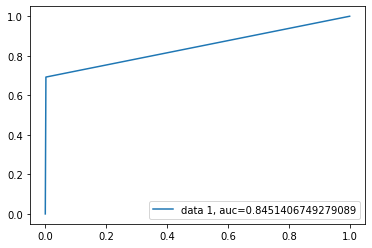

In [74]:
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, xgboost_optimized.predict(X_test))
roc_auc = metrics.auc(fpr, tpr)
print("Score -->",roc_auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()


#### We saw a substancial improvement in the model performance when compared to our base model. The F-1 score increased from 0.68 to 0.75 i.e. approximately by 10%. Now, lets try to build models using second technique to tackle with imbalanced target.

#### 2. Cost Sensitive Learning 

In [59]:
# Computing class weight
class_weight = int(y_train.value_counts()[0] / y_train.value_counts()[1])
print(class_weight)

76


In [60]:
# Setting up base models
models_2 = {'XGBoost': xgboost.XGBClassifier(scale_pos_weight=class_weight),
            'Support Vector Machines' : SVC(kernel='rbf',class_weight={0:1,1:class_weight}), 
            'Random Forest Classifier' : RandomForestClassifier(class_weight={0:1,1:class_weight})}
f1_scores_2 = []
for name, model in models_2.items():
    print("Algorithm -----> ", name, '\n')
    m = model.fit(X_train, y_train)
    f1_scores_2.append((name, f1_score(y_test, m.predict(X_test))))
    
print("F1-Scores from each models :\n")
print(f1_scores_2)
print("\n Maximum F1-Score is given by : \n")
print(max(f1_scores_2))

<IPython.core.display.Javascript object>

Algorithm ----->  XGBoost 

Algorithm ----->  Support Vector Machines 

Algorithm ----->  Random Forest Classifier 

F1-Scores from each models :

[('XGBoost', 0.7272727272727273), ('Support Vector Machines', 0.32911392405063294), ('Random Forest Classifier', 0.14285714285714288)]

 Maximum F1-Score is given by : 

('XGBoost', 0.7272727272727273)


#### Cost sensitive learning approach gave us better results from the SMOTETomek approach for XGBoost. Whereas, resampling the dataset and then training it proved to be better incase of SVM and Random Forests. However, our aim is to build the most effective predictive model and hence, we will stick to XGBoost. Let's optimize it further. 

In [61]:
# Defining paramter dictionary

# We will be passing various values of missclassification penalty to the "scale_pos_weight" in parameter dictionary
params_2 = {
    "scale_pos_weight" : [45,60,75,90],
    "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth" : [3,4,5,6,8,10,12,15],
    "min_child_weight" : [1,3,5,7],
    "gamma": [0.0,0.1,0.2,0.3,0.4],
    "colsample_bytree" : [0.3,0.4,0.5,0.6,0.7]
}

classifier_2 = xgboost.XGBClassifier()
random_search_2 = RandomizedSearchCV(classifier_2, param_distributions=params_2,n_iter=10,scoring='f1',n_jobs=-1,cv=5,verbose=3)
random_search_2.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.5s finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                      

In [62]:
print(random_search_2.best_estimator_)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=75, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)


In [63]:
xgboost_optimized_2 = xgboost.XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=0, max_depth=15,
              min_child_weight=3,  monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=90, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

xgboost_optimized_2.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=0, max_depth=15,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=90, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

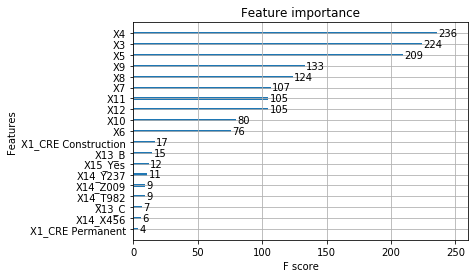

In [64]:

from xgboost import plot_importance
xgboost_optimized_2.feature_importances_
plot_importance(xgboost_optimized_2)

#### From the feature importances from XGBoost, we are able to infer that features X4, X3 and X5 rank in the top 3 best predictors of default. This was expected because they had a better correlation coefficient than other features. However, there's an interesting situation here. The numerical features are good predictors in combination than the categorical features, although the correlation values with target is almost similar incase of both the feature types.  

In [65]:
print("F-1 Score after optimization: ", f1_score(y_test.values, xgboost_optimized_2.predict(X_test)))

F-1 Score after optimization:  0.8108108108108107


In [66]:
print("Confusion Matrix:\n--------------\n")
print(confusion_matrix(y_test.values, xgboost_optimized_2.predict(X_test)))

Confusion Matrix:
--------------

[[2956    5]
 [   9   30]]


Score --> 0.883771075260437


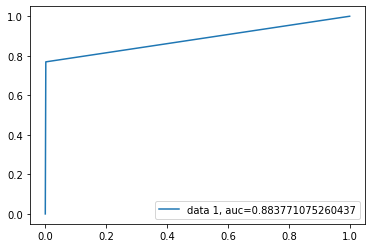

In [67]:
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, xgboost_optimized_2.predict(X_test))
roc_auc = metrics.auc(fpr, tpr)
print("Score -->",roc_auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()


In [68]:
# Serializing the model using pickle 
with open(r'C:\Users\Deep Joshi\Desktop\Mom and Dad\Mom\model_pickle_optimized_XGBoost','wb') as f:
        pickle.dump(xgboost_optimized_2,f)

<IPython.core.display.Javascript object>

#### Both the models gave us similar results i.e. an F1-Score of approximately 0.75, however, let's treat result from the second method as our final model. 

### PCA 

#### Now, let's proceed ahead with the second stage of feature selection. Since, we have already built the base models with all the features, let's move ahead and perform Principal Component Analyis(PCA)

<BarContainer object of 17 artists>

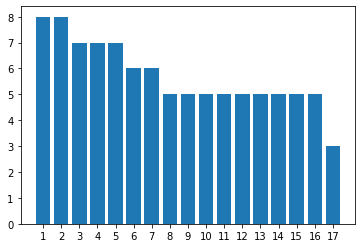

In [69]:
pca = PCA(0.95)
pca.fit_transform(X_train)
train_PCA = pca.transform(X_train)
test_PCA = pca.transform(X_test)
per_var = np.round(pca.explained_variance_ratio_*100)
labels = [str(x) for x in range(1,len(per_var)+1)]


plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)

#### 17 principal components are required to preseve 95% of variance

In [70]:
xgb_PCA = xgboost.XGBClassifier(scale_pos_weight=class_weight)
xgb_PCA.fit(train_PCA, y_train)
print("F-1 Score after PCA: ", f1_score(y_test, xgb_PCA.predict(test_PCA)))

F-1 Score after PCA:  0.23728813559322035


#### As we saw above, PCA did not increase the performance of the model and this was expected. There are multiple reasons: our dataset has too much overlappings among the data points and lacks a distinct split, PCA assumes linearity which is not the case in our dataset and finally, PCA makes use of variance to calculate important dimensions and hence, high variance axes are treated as components and low variance as noise. 

# --------------------------------------------------------------------------------------------------------------